<a href="https://colab.research.google.com/github/HassanDuffaydar/Airline-Webscraping/blob/main/Week_3_Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimisation

The focus of this notebook is going to walking through an example of constructing an Efficient Frontier - a key part of Modern Portfolio Theory!

## Part 1: Importing the libraries and data

In [ ]:
#First we want to import the libraries necessary for computing returns, risk, and plotting our graphs

import numpy as np
import pandas as pd
import yfinance as yf

#These imports are all related to plotting our graphs, so we dont need to worry too much about these!

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
#Lets now retrieve our historical financial data that we are going to use

tickers = 'MSFT AAPL AMZN NVDA GOOGL META JPM PG JNJ ADBE SPY' #Tickers so yfinance knows what stocks to get data for
df = yf.download(tickers = tickers, start = '2013-01-01', end = '2023-01-01', interval = '1d') #Parameters for yfinance
df.head()

We are going to be computing historical returns - which stock values do we care about most in this instance?

**Adjusted close!**

What does the 'adjusted' in adjusted close price actually mean?

**Adjusted close price just means the stock's close price that has been modified to include the effects of corporate actions i.e.**
- **Stock splits**
- **Dividend payouts**



In [ ]:
#Here we only retrieve the adjusted close price, and then resample to get the adjusted close price for the last day of each year

df = df.xs('Adj Close', axis = 1) #.xs will select only the adjusted close values for each stock
df = df.resample('YE').last() #.resample will adjust the frequency of our time-series data, and in this case retrieve only the last close value of each stock, each year
df

To plot our efficient frontier, we are going to need

In [ ]:
#We want to calculate the historical annual returns of each of our stock, to ultimately be used as a predictor for future returns

annual_returns = df.apply(lambda x: x.pct_change()).dropna() #Calculate the annual percentage change of each stock (from the last day of each year) and put this in a new df
annual_returns

In [ ]:
#Calculate the mean of all our stock's annual returns over the years, to serve as our (bad and limited) predictor for future expected return!

ann_return = annual_returns.mean() #Our model here is just taking the mean of our historical annual returns, and setting this as our future returns
ann_return #This will serve as our future return

To clarify what we are doing here:
- Alex discussed several ways to predict (forecast) future returns for our stocks
- And based off these forecasted returns, there are several ways to optimise our portfolio (MC simulations, BL model)


In this case, we are taking the mean of our historical annual returns, and **assuming** this will be our future returns

We are then going to run Monte Carlo (random) simulations, and see which asset combination gives us the highest Sharpe



In [ ]:
#Calculate a covariance matrix based on our historical annual returns dataframe, for use when calculating risk later on!

ann_cov = annual_returns.cov()
ann_cov

#Output is a covariance matrix
#Notice anything about this matrix
#What do the diagonal terms represent

Checkpoint:
- We have calculate our future returns for our assets
- We have a covariance matrix that can be used when calculating the risk of our portfolio

**Next thing to do is run some simulations!**

## Part 2: Creating our portfolios to plot


We are going to produce 10000 random portfolios based on our calculated future returns and variance data
- We will assess each portfolios performance graphically in return-risk space

In [ ]:
#First we set how many assets we want in our portfolio and the amount of portfolios we want to generate

n_assets = 7 #Must be less than or equal to number of assets in our portfolio
n_portfolios = 10000 #Number of portfolios being created
np.random.seed(75) #For the random weight generation


Link for more information the equations used:

https://quant.stackexchange.com/questions/43442/portfolio-variance-explanation-for-equation-investments-by-zvi-bodie

In [ ]:
#This code includes a loop to generate portfolios, creating expected return and variance for each one

asset_list = [] #What might these lists be for?
weights_list = []
mean = []
variance = [] #These lists are to store the attributes of every portfolio generated

#This loop is for every portfolio(n)

for n in range(n_portfolios): #For loop of length number of portfolios

    assets = np.random.choice(list(annual_returns.columns), n_assets, replace = False) #This randomly selects 7 elements from our total list of stocks, for portfolio(n), and replace = False ensures no duplicate assets
    asset_list.append(assets) #We append our list assets for portfolio(n) to our global asset_list

    weights = np.random.rand(n_assets) #This generates an array of random numbers, between 0 and 1, with the length of n_assets (in our case 7)
    weights = (weights / sum(weights)).round(4) #This then performs divides each element in our array by the sum of all elements in the array, and then round it to 4 (which is actually 2dp because 0.4245 = 42.45% weighting)
    weights_list.append(weights) #Similiar to before, we append our list of weights to our global weights list

    port_exp_ret = 0 #Resets the return and variance of the portfolio for each iteration
    port_exp_var = 0

    #This loop is now for each individual asset within our portfolio(n)

    for i in range(len(assets)): #For asset(i) within portfolio(n)
        port_exp_ret += weights[i] * ann_return.loc[assets[i]] #Iterating through each asset in the portfolio and adding the assets weighted return to the overall portfolio return

        for j in range(len(assets)):
            port_exp_var += weights[i] * weights[j] * ann_cov.loc[assets[i], assets[j]] #This calculates our variance of asset(i) with all other assets in the portfolio, for every asset!

    mean.append(port_exp_ret) #Like before we add our mean and variance for our portfolio to our global lists
    variance.append(port_exp_var)

The equation for variance is as follows:

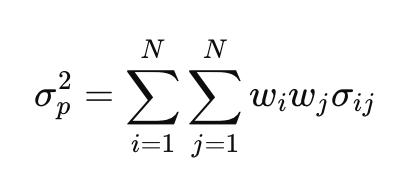

This relates to our loop, where we are multiplying the weights of asset(i) and asset (j), and then by their covariance

Here we can investigate what each list contains:

In [ ]:
asset_list

In [ ]:
print(len(asset_list))

In [ ]:
weights_list

We want our data to be organised in a hassle free way, so we can easily plot and manipulate our data

**For this reason we will put it all into a dataframe!**

In [ ]:
#Creating our dataframe - here we see why all our lists were so useful!

plot_data = pd.DataFrame(index = range(n_portfolios), data = zip(mean, variance, asset_list, weights_list),
                         columns = ['Return', 'Variance', 'Asset List', 'Asset Weights']) #Creating our dataframe and passing in all our lists
plot_data

In [ ]:
#Calculate the Sharpe Ratio for each portfolio, and add this data to our dataframe for plotting

plot_data['Sharpe Ratio'] = (plot_data['Return'] - 0.05) / plot_data['Variance']**0.5 #What might 0.05 mean here? What about the **0.5?
plot_data

Sharpe Ratio formula... incase we forgot!

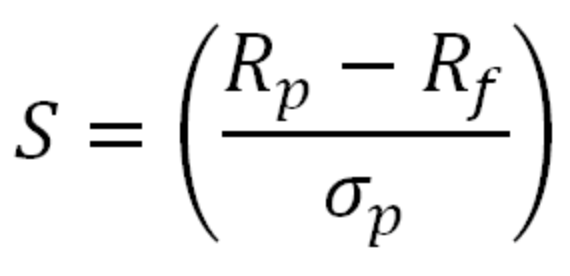

In [ ]:
len(plot_data) #Check the length of our dataframe

## Part 3:Plotting the Efficient Frontier graph


Using plotly we can make excellent interactive graphs to display our different portfolios

In [ ]:
fig = go.Figure() #Creates an instance of go (graph object) similiar to figure = plt.figure

plot_data['HoverText'] = [
    f"Assets: {assets}<br>Weights: {weights}<br>Annualised Return: {mean}<br>Annualised Risk: {variance}"
    for assets, weights, mean, variance in zip(plot_data['Asset List'], plot_data['Asset Weights'], plot_data['Return'], plot_data['Variance']**0.5)
]

fig.add_trace(go.Scatter(x=plot_data['Variance']**0.5, y=plot_data['Return'], #Note our x axis becomes standard deviation so is square rooted
                      marker=dict(color=plot_data['Sharpe Ratio'], #Mark each point by its sharpe ratio
                                  showscale=True, #Parameters for the marker
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ),
                      mode='markers', text=plot_data['HoverText'],  # Pass the formatted text
    hovertemplate="%{text}<extra></extra>"))

fig.update_layout(template='plotly_white', #Generic formatting
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=1250,
                  height=900)

fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

# Data Analysis on our Portfolios

By utilising the versatility of Pandas and DataFrames, we can extract meaningful insights on our different portfolios

In [ ]:
#We can search for max values from our dataframe

plot_data['Sharpe Ratio'].idxmax() #.idxmax locates the row with the maximum sharpe ratio

In [ ]:
#What if we want to know more about our portfolio with the highest sharpe ratio?

plot_data.iloc[plot_data['Sharpe Ratio'].idxmax()] #Outputs the related info

In [ ]:
#We can also search for portfolios with risk (standard deviation of our portfolio) below a certain level, and then order them by which metric we want!

plot_data[plot_data['Variance']**0.5 < 0.3].sort_values('Sharpe Ratio', axis =0, ascending = False) #Square rooting our variance to get standard deviation

#Here we are ordering our portfolios by the best sharpe ratio at a volatility (standard deviation) of less than 30%

## Extra: Improving the graph and adding features

How could we improve our graph / make it easier to only look at the **best** portfolios?
- Add a 'dominating' condition

What do we mean by a 'dominating' condition?

Theres are lots of portfolios below the efficient frontier, so we may as well get rid of these!
- If two portfolios have equal return, we will chose the one with less risk, and similiarly at the same risk level we want the most return

In [ ]:
#Same code as before, but the variables have an _2 so previous lines of code can be ran / messed around with without variables issues

n_assets_2 = 7
n_portfolios_2 = 10000

asset_list_2 = []
weights_list_2 = []
mean_2 = []
variance_2 = []

for n in range(n_portfolios_2):

    assets = np.random.choice(list(annual_returns.columns), n_assets_2, replace = False)
    asset_list_2.append(assets)

    weights = np.random.rand(n_assets_2)
    weights = (weights / sum(weights)).round(4)
    weights_list_2.append(weights)


    port_exp_ret = 0
    port_exp_var = 0

    for i in range(len(assets)):
        port_exp_ret += weights[i] * ann_return.loc[assets[i]]

        for j in range(len(assets)):
            port_exp_var += weights[i] * weights[j] * ann_cov.loc[assets[i], assets[j]]

    mean_2.append(port_exp_ret)
    variance_2.append(port_exp_var)

In [ ]:
#Same as before we create our dataframe

plot_data_2 = pd.DataFrame(index = range(n_portfolios_2),data = zip(mean_2, variance_2, asset_list_2, weights_list_2), columns = ['Mean', 'Variance', 'Asset List', 'Asset Weights'])
plot_data_2['Sharpe Ratio'] = (plot_data_2['Mean'] - 0.05) / plot_data_2['Variance']**0.5
plot_data_2

In [ ]:
#Dominating condition to filter out our undesirable portfolios

mean_var_pairs = plot_data_2[['Mean', 'Variance']].to_numpy() #This gets our mean and variance from our portfolios and makes it into a 2d array to be iterated through
dominant_portfolio = [] #We create an empty array for our desirable portfolios, note this is a 2d array that will be important later!

for R_tocheck, V_tocheck in mean_var_pairs: #R_tocheck and V_tocheck is the return and variance of each portfolio, and will loop through each portfolio in in our dataframe

    should_append = True   #Initial condition is that our selected portfolio from the mean_variance_pairs array is a dominant portfolio

    for R,V in mean_var_pairs: #Second loop which will compare the R_tocheck and V_tocheck against every other portfolio created
        if (R > R_tocheck) & (V < V_tocheck): #If the portfolio is dominated by any other, we break out the loop and dont add it to dominant pairs array
            should_append = False
            break

    if should_append == True:
        dominant_portfolio.append([R_tocheck, V_tocheck])   #If the R_tocheck and V_tocheck portfolio isnt dominated by any other, we add it to our dominant pairs list

In [ ]:
mean_var_pairs

Summary of the above code:
- Two loops that compares one mean_variance pair against all other paris in our dataframe
- If our 'check' portfolio isnt dominated by any other, it is a dominant portfolio
- Check every portfolio against every other in the portfolio list

In [ ]:
#Now we are creating our new dataframe through a merge with the original dataframe, on our dominant portfolios

dominant_df = pd.DataFrame(index = range(len(dominant_portfolio)), data = dominant_portfolio, columns = ['Mean', 'Variance'])
dominant_df = pd.merge(dominant_df, plot_data_2, how = 'left') #Merged on the dominant portfolios, meaning only dominant values are carried over
dominant_df

In [ ]:
#Our original amount of portfolios

len(plot_data_2)

In [ ]:
#Our new amount of dominant portfolios

len(dominant_df)

In [ ]:
#Same code as before

fig = go.Figure()

fig.add_trace(go.Scatter(x=dominant_df['Variance']**0.5, y=dominant_df['Mean'],
                      marker=dict(color=dominant_df['Sharpe Ratio'],
                                  showscale=True,
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ),
                      mode='markers'))

fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Dominant Portfolios',
                  width=850,
                  height=500)

fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

## Is all this worth it? Why not just buy and hold?

Lets get the Sharpe Ratios if we bought and held our individual stocks, and see if portfolio optimisation beats it!

In [ ]:
#First lets just grab the mean of each stocks historical annual return, and add it to a new dataframe

stocks_return = ann_return
stocks_return

In [ ]:
#Now lets remind ourselves of our covariance matrix from earlier

ann_cov #From here were are only interested in the variance of each stock (to sqrt so we get standard deviation to then get Sharpe ratio) so we look at the diagonal

In [ ]:
#Lets grab each stock's variance through a simple for loop that iterates through, and adds each diagonal value to a list

stocks_variance = []
for i in range(len(ann_cov.columns)):
    stocks_variance.append(ann_cov.iloc[i][i])
stocks_variance

In [ ]:
#Lets add it all together, and calculate the Sharpe Ratio while we are at it

brand_df = pd.DataFrame({'Return': stocks_return.values.flatten(), 'Variance': stocks_variance},  index=ann_return.index) #Create the new dataframe
brand_df['Sharpe Ratio'] = (brand_df['Return'] - 0.05 / brand_df['Variance']**0.5) #Add a Sharpe Ratio column
brand_df

In [ ]:
#Sort by Sharpe Ratio to see the best performing stock

brand_df['Sharpe Ratio'].sort_values(ascending=False)

In [ ]:
#Compare it to our highest Sharpe Ratio portfolio...

dominant_df.iloc[dominant_df['Sharpe Ratio'].idxmax()]

In [ ]:
print("The sharpe ratio of our best portfolio was " + str(dominant_df['Sharpe Ratio'].max()) + " while if we bought and held the best performing stock in our portfolio, we would only achieve " + str(brand_df['Sharpe Ratio'].max()))

**So using portfolio optimisation is superior!**

# Coding challenge!

The task for you guys:
- Using the the given data set, find the top 5 portfolios with the highest sharpe ratio for 0.3 volatility
- Find the portfolio with the best sharpe ratio overall - you can also try and plot an Efficient Frontier graph!

Hint:
- Pandas has really good documentation online on dataframe conditional filtering
- .idxmax and .loc (!)

In [ ]:
#Getting our data
chall_tickers = 'AAPL MSFT AMZN NVDA META AVGO GOOGL GOOG TSLA ADBE COST PEP CSCO NFLX AMD'
chall_df =  yf.download(tickers = chall_tickers, start = '2013-01-01', end = '2023-01-01', interval = '1d')
chall_df = chall_df.xs('Adj Close', axis = 1)
chall_df = chall_df.resample('YE').last()

#Getting our daily returns
chall_annual_returns = chall_df.apply(lambda x:x.pct_change()).fillna(0)

#Getting our mean and variance data
chall_ann_return = chall_annual_returns.mean()
chall_ann_cov = chall_annual_returns.cov()

#Create some parameters for generating our random portfolios
chall_n_assets = 5
chall_n_portfolios = 1000
np.random.seed(75)

In [ ]:
#Creating our lists
chall_asset_list = []
chall_weights_list = []
chall_mean = []
chall_variance = []

#Creating our random portfolios
for i in range(chall_n_portfolios):

    assets = np.random.choice(list(chall_annual_returns.columns), chall_n_assets, replace = False)
    chall_asset_list.append(assets)
    weights = np.random.rand(chall_n_assets)
    weights = (weights / sum(weights)).round(4)
    chall_weights_list.append(weights)

    port_exp_ret = 0
    port_exp_var = 0

    for i in range(len(assets)):
        port_exp_ret += weights[i] * chall_ann_return.loc[assets[i]]
        for j in range(len(assets)):
            port_exp_var += weights[i] * weights[j] * chall_ann_cov.loc[assets[i], assets[j]]
    chall_mean.append(port_exp_ret)
    chall_variance.append(port_exp_var)

In [ ]:
#Creating our dataframe for our portfolios
chall_data = pd.DataFrame(index = range(chall_n_portfolios),data = zip(chall_mean, chall_variance, chall_asset_list, chall_weights_list),
                         columns = ['Mean', 'Variance', 'Asset List', 'Asset Weights'])
chall_data['Sharpe Ratio'] = (chall_data['Mean'] - 0.05) / chall_data['Variance']**0.5

chall_data

Whats next!